Group songs per artist and album:

In [2]:
library(igraph)
library(dplyr)
library(rjson)

songs <- list()
data.path <- "data/"

artist <- c()
album <- c()
year <- c()
song <- c()
chords <- c()
energy <- c()
tempo <- c()
acousticness <- c()
duration <- c()
danceability <- c()
valence <- c()

for (file.name in list.files(path=data.path)) {
  if (startsWith(file.name, "data")) {
    artist.songs <- fromJSON(file=paste0(data.path, file.name))
    artist <- c(artist, sapply(artist.songs, function(x) x$artist))
    album <- c(album, sapply(artist.songs, function(x) x$album))
    year <- c(year, sapply(artist.songs, function(x) x$year))
    song <- c(song, sapply(artist.songs, function(x) x$name))
    energy <- c(energy, sapply(artist.songs, function(x) x$energy))
    tempo <- c(tempo, sapply(artist.songs, function(x) x$tempo))
    acousticness <- c(acousticness, sapply(artist.songs, function(x) x$acousticness))
    duration <- c(duration, sapply(artist.songs, function(x) x$duration))
    danceability <- c(danceability, sapply(artist.songs, function(x) x$danceability))    
    valence <- c(valence, sapply(artist.songs, function(x) x$valence))                          
    chords <- c(chords, sapply(artist.songs, function(x) x$chords))
  }
}

songs.df <- data.frame(artist=artist, album=album, year=year, song=song, 
                       duration=duration, energy=energy, tempo=tempo, 
                       acousticness=acousticness, danceability=danceability,
                       valence=valence, chords=chords)

Warning message:
“package ‘igraph’ was built under R version 3.4.4”
Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Warning message:
“package ‘dplyr’ was built under R version 3.4.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘rjson’ was built under R version 3.4.4”

Aggregate attributes per album:

In [3]:
albums.df <- songs.df %>%
  filter(chords != "") %>%
  group_by(artist, album, year) %>%
  summarise(energy = mean(energy), tempo = mean(tempo),
            acousticness = mean(acousticness), duration = mean(duration),
            danceability = mean(danceability), valence = mean(valence),
            chords = paste(chords, collapse=".\n")) %>%
  ungroup()

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

Create list of graphs, one per album. A graph will use the actual chords as vertices and there will be an edge between two of them if they are consecutive in any of the songs of the album. Note that the last chord of a song is not connected to the first one of the following song of the same album. The weight of the edges shows how many times that connection happened thoughout the album, so the higher the weight, the more often those chords are consecutive.

In [4]:
graphs <- list()
for(i in 1:nrow(albums.df)) {
  chord_sequence <- c()
  song.chords <- strsplit(as.character(albums.df[i, "chords"]), ".\n")[[1]]
  for (song in song.chords) {
    chords <- strsplit(song, ", ")[[1]]        
    for(i in 1:(length(chords)-1)){
        if (chords[i] != chords[i+1]) {
          chord_sequence <- append(chord_sequence, c(chords[i], chords[i+1]))
        }
    }
  }
  graphs <- append(graphs, list(graph(chord_sequence)))
}

# Metrics Computation

[1] "Album: You Could Have It So Much Better"


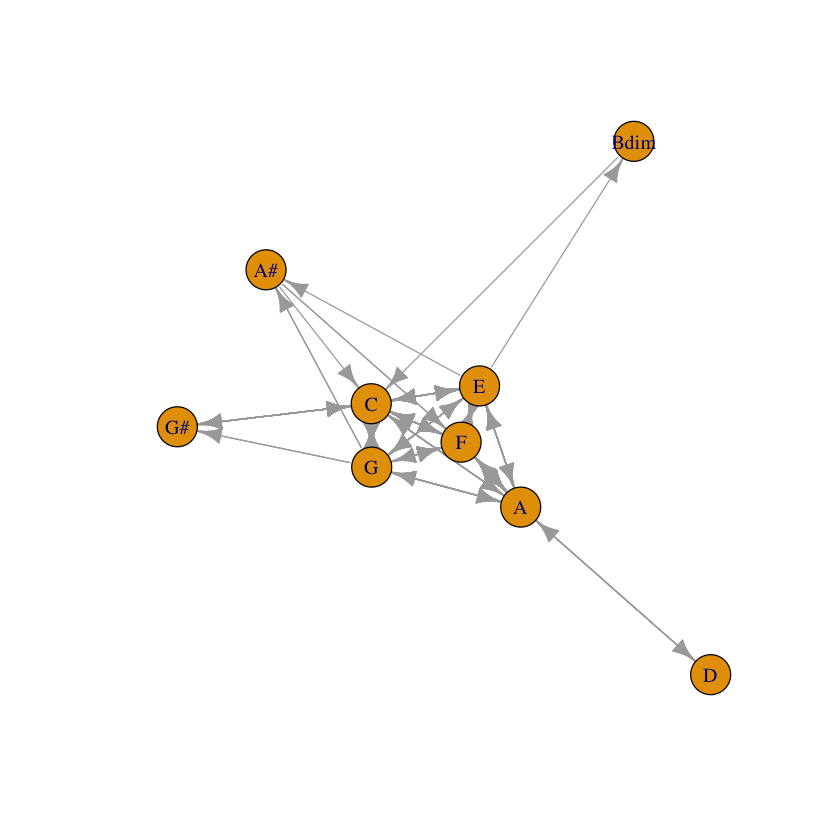

In [5]:
print(paste("Album:", albums.df$album[11]))
plot(graphs[[11]], edge.curved=0)

In [6]:
column_names <- c("N", "E", "k", "delta", "diameter", "cc")
metrics <- data.frame(matrix(ncol = length(column_names), nrow = 0))
colnames(metrics) <- column_names
                      
for (graph in graphs) {
    N <- vcount(graph)
    E <- ecount(graph)
    df <- data.frame(N=N, E=E, k=2*E/N, delta=2*E/(N*(N-1)), diameter=diameter(graph), cc=transitivity(graph))
    metrics <- rbind(metrics, df)
}
                      
row.names(metrics) <- albums.df$album
metrics

,N,E,k,delta,diameter,cc
AM,10,820,164.00000,18.222222,3,0.6000000
Favourite Worst Nightmare,22,648,58.90909,2.805195,6,0.4333333
Humbug,15,636,84.80000,6.057143,5,0.5185185
Suck It and See,27,1527,113.11111,4.350427,6,0.5151515
Tranquility Base Hotel & Casino,50,1659,66.36000,1.354286,5,0.3423512
"Whatever People Say I Am, That's What I'm Not",24,788,65.66667,2.855072,6,0.4520548
Always Ascending,11,402,73.09091,7.309091,3,0.7288136
Franz Ferdinand,24,336,28.00000,1.217391,7,0.4308511
"Right Thoughts, Right Words, Right Action",11,674,122.54545,12.254545,3,0.6532258
Tonight: Franz Ferdinand,14,320,45.71429,3.516484,3,0.5806452


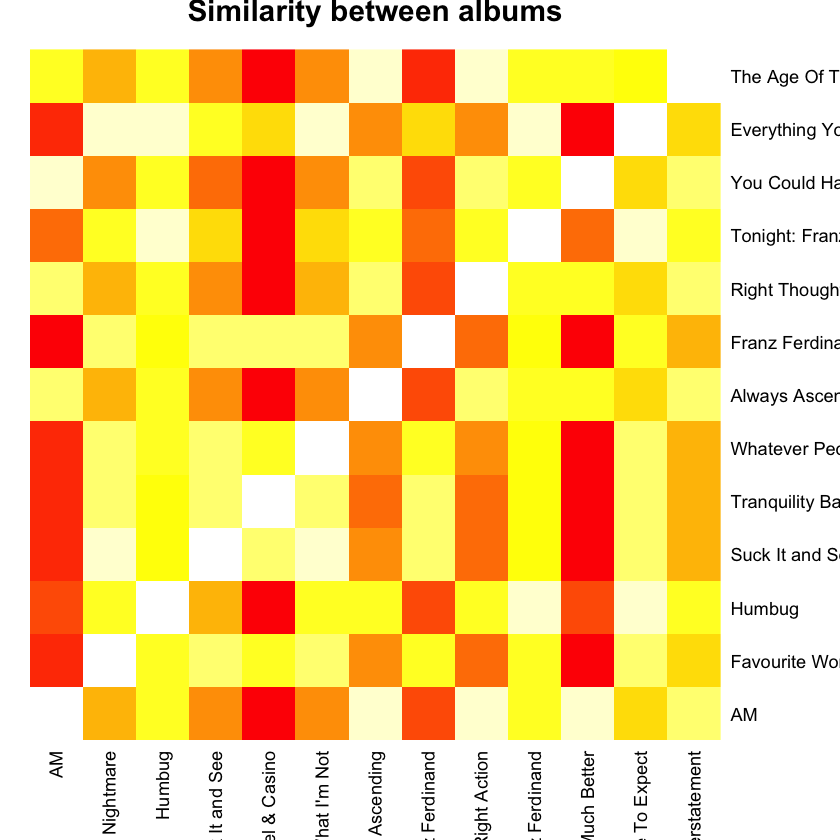

In [7]:
library(reshape2)

albums <- t(metrics)
corr.matrix <- round(cor(albums), 3)
diag(corr.matrix) <- NA
heatmap(as.matrix(corr.matrix), Colv = NA, Rowv = NA, main = "Similarity between albums", scale = 'none')

## Degree distribution

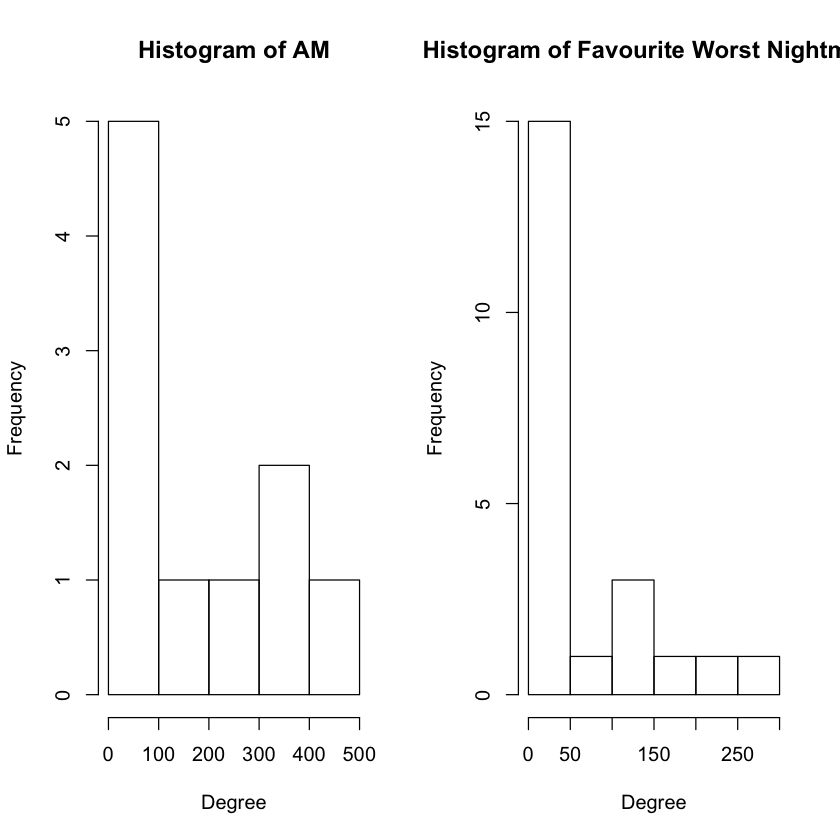

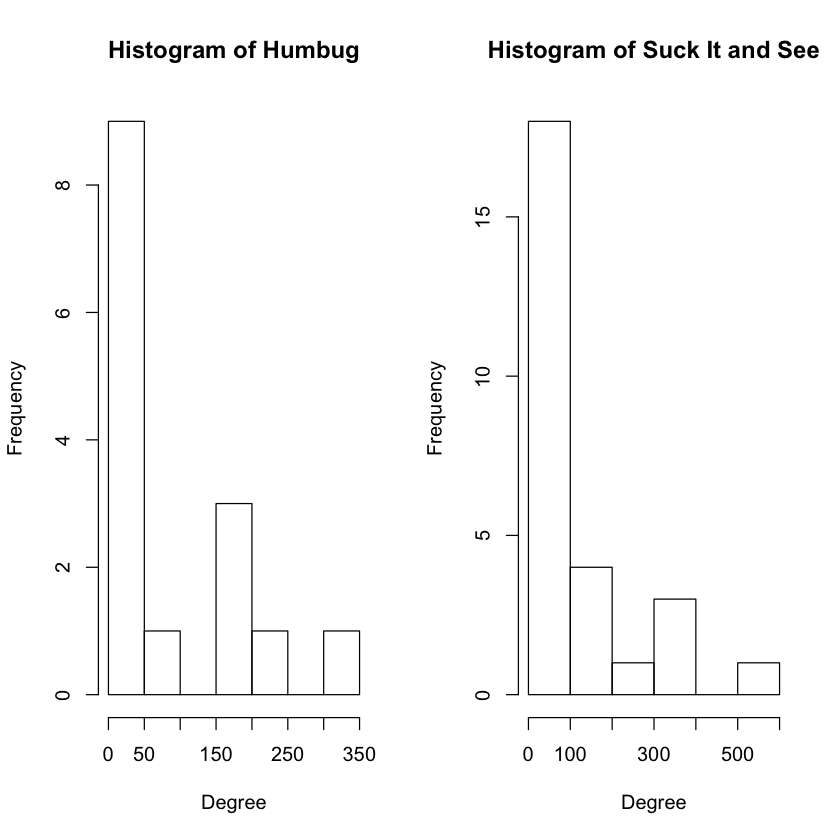

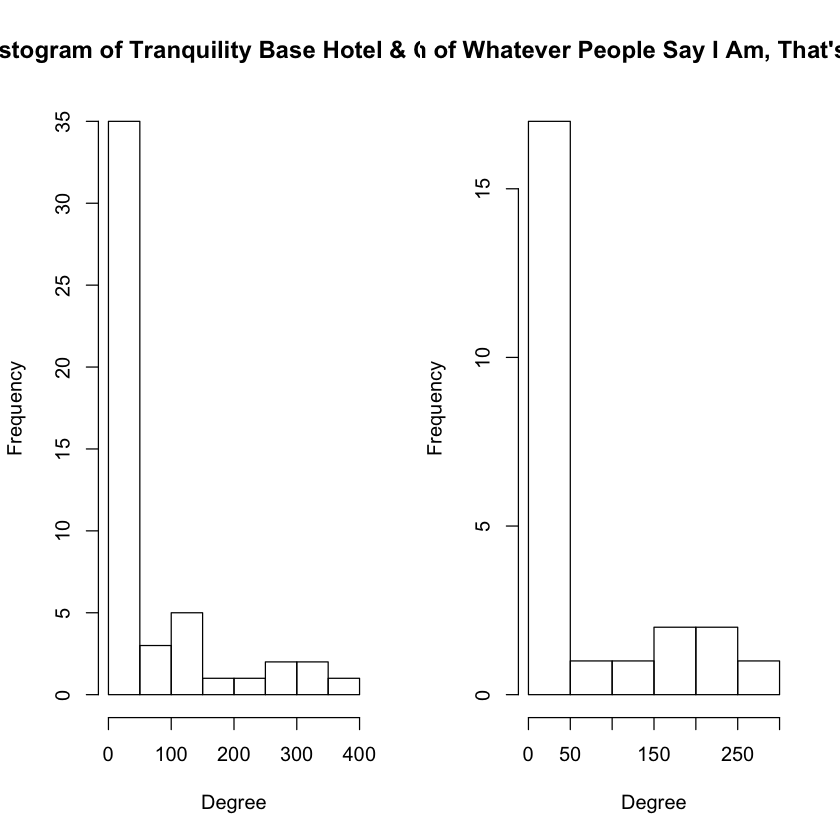

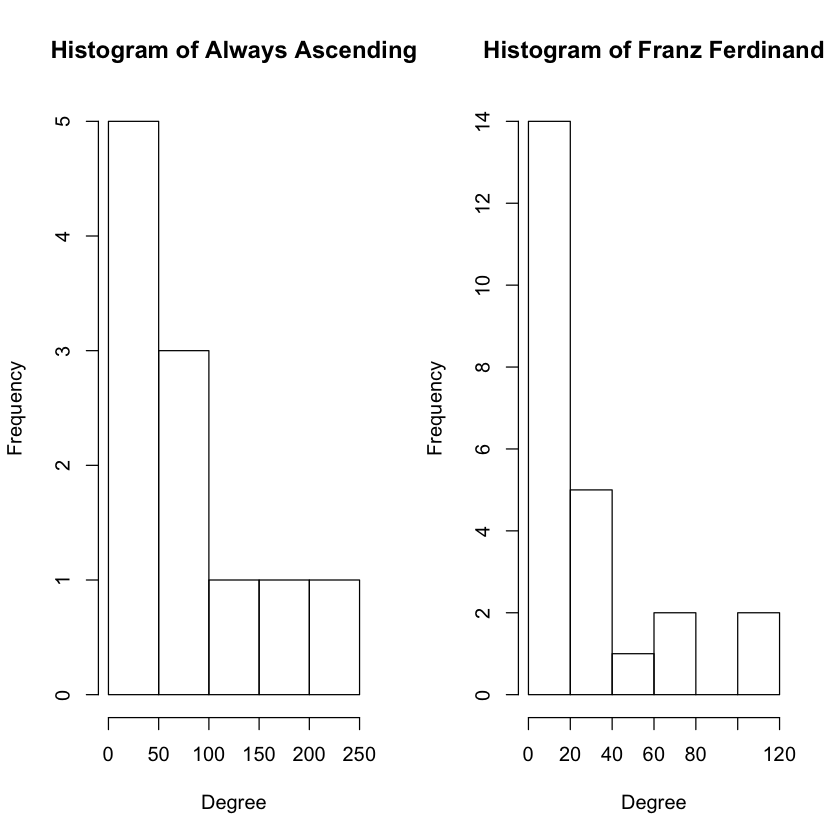

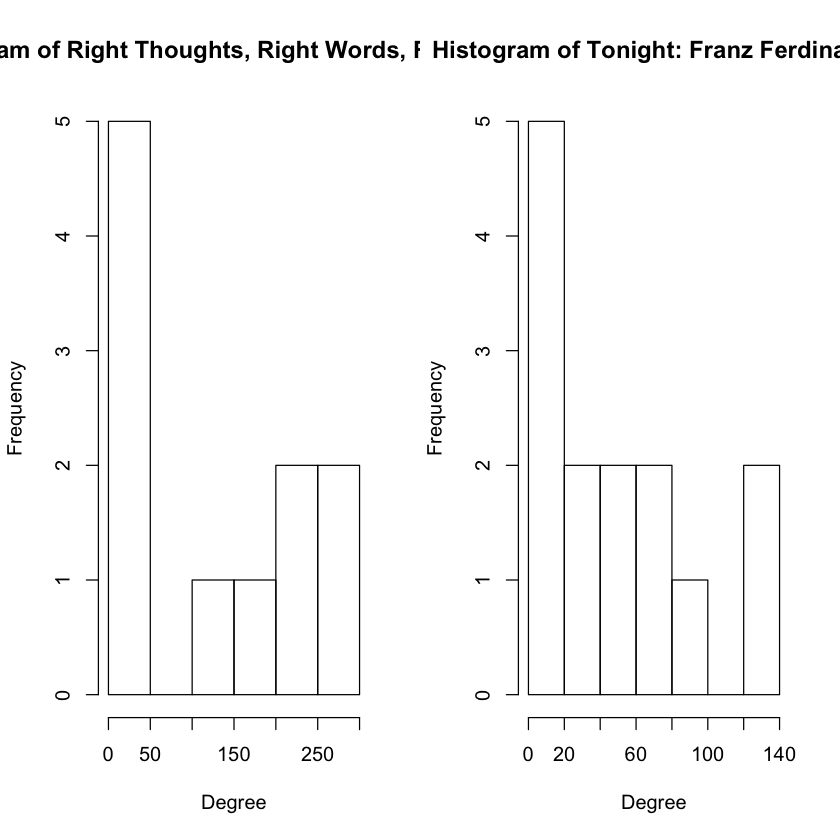

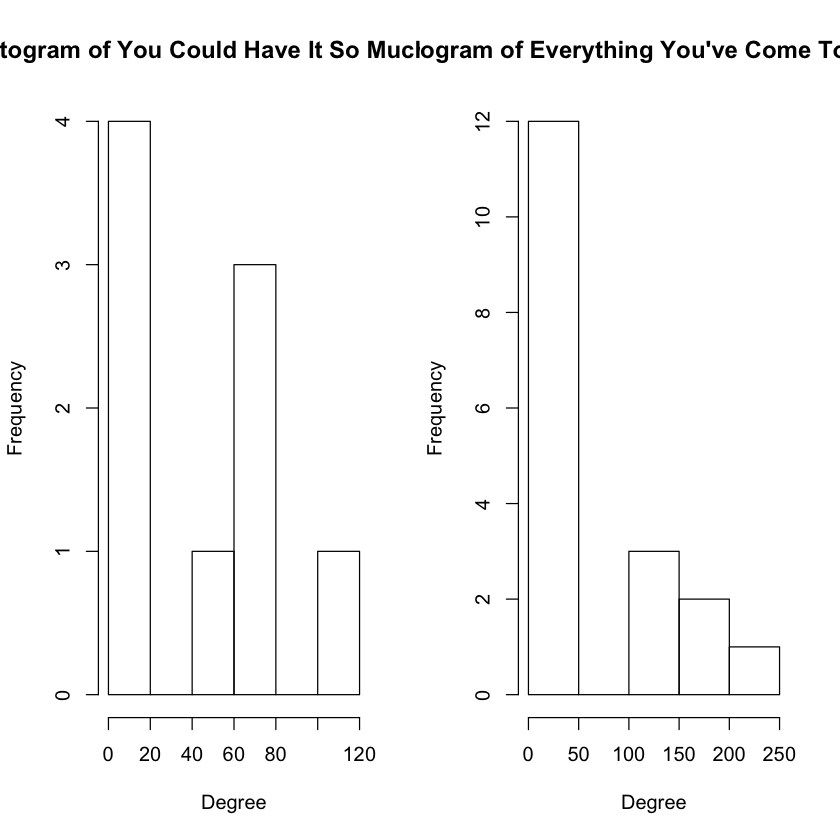

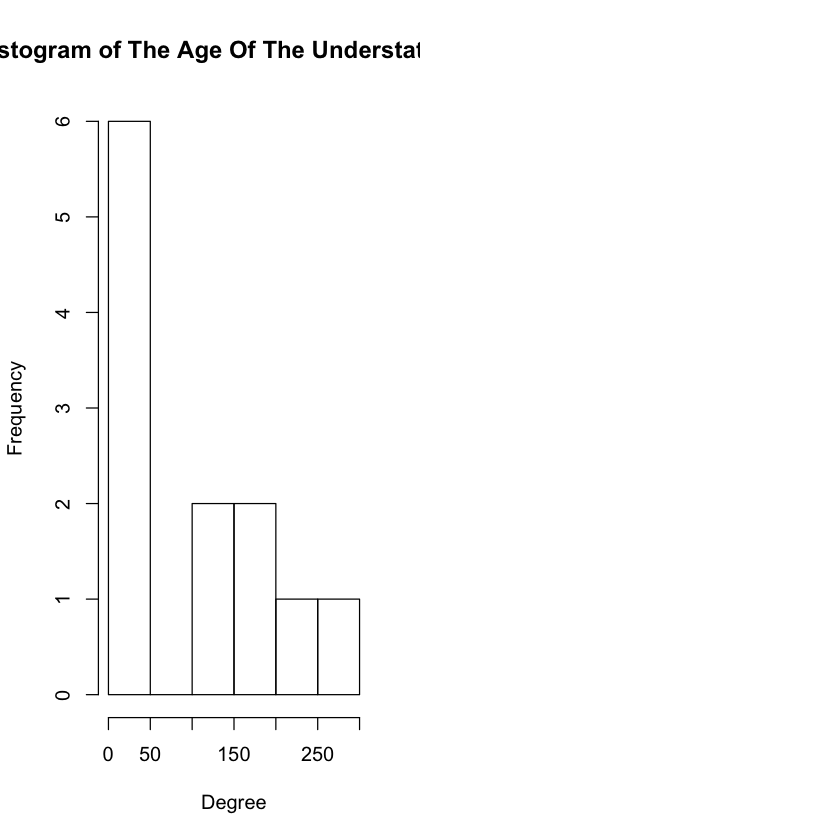

In [8]:
par(mfrow=c(1,2))

for (i in 1:length(graphs)) {
    hist(degree(graphs[[i]]), main = paste0("Histogram of ", albums.df$album[i]), xlab = "Degree")
}

# Relatedness Using Neumann Kernels

In [9]:
K_hat_list <- list()
T_hat_list <- list()

for (graph in graphs) {
    A <- as.matrix(as_adj(graph))
    At <- t(A)
    K <- At %*% A
    T <- A %*% At

    max_indegree <- max(colSums(A))
    max_outdegree <- max(rowSums(A))

    gamma_upper_bound <- 1/min(max_indegree, max_outdegree)

    gamma <- gamma_upper_bound # This value must be between 0 and "gamma_upper_bound"

    K_hat <- K %*% solve(diag(dim(K)[1]) - gamma * K)
    T_hat <- T %*% solve(diag(dim(T)[1]) - gamma * T)

    K_hat_list <- append(K_hat_list, list(K_hat))
    T_hat_list <- append(T_hat_list, list(T_hat))
}

Using as $\gamma$ its upper bound, we get that the rankings of importance per album are the following.

In [10]:
for (i in 1:length(K_hat_list)) {
    print(as.character(albums.df$album[i]))
    print(names(sort(rowSums(K_hat_list[[i]]))))
}

[1] "AM"
 [1] "C"  "A"  "F"  "G#" "E7" "C7" "B"  "D"  "G"  "E" 
[1] "Favourite Worst Nightmare"
 [1] "C"     "D"     "A#"    "C#"    "A"     "G"     "E"     "E7"    "F"    
[10] "D#"    "A7"    "Dsus2" "C#5"   "F#5"   "A#5"   "D5"    "G#5"   "C5"   
[19] "E5"    "D#5"   "B5"    "G#m"  
[1] "Humbug"
 [1] "B"     "E"     "A"     "C"     "D"     "F"     "G"     "D6"    "G6"   
[10] "G#"    "A#"    "E7"    "Asus2" "A5"    "D5"   
[1] "Suck It and See"
 [1] "C"     "A#5"   "D#"    "F#5"   "E5"    "B5"    "F5"    "G"     "D#m"  
[10] "A"     "A#"    "F"     "G#"    "F#"    "D5"    "E"     "G7"    "F7"   
[19] "Fmaj7" "B"     "Dsus2" "C#m"   "D7"    "D"     "C5"    "C#"    "A#m"  
[1] "Tranquility Base Hotel & Casino"
 [1] "B"       "F"       "F#"      "G"       "D7"      "D"       "F7"     
 [8] "F#aug"   "C7"      "C#"      "A#7"     "D#aug"   "G7"      "B7"     
[15] "Fdim7"   "Gmaj7"   "Bsus2"   "E6"      "C#7"     "C"       "G#m7b5" 
[22] "F#sus4"  "C#dim7"  "C#madd6" "D#dim"   "D#m"    

In [16]:
album_names <- albums.df$album
chord_ranks <- vector("list", length(album_names))
names(chord_ranks) <- album_names

for (i in 1:length(K_hat_list)) {
  album_name <- as.character(album_names[i])
  chord_ranks[[album_name]] <- list(names(sort(rowSums(K_hat_list[[i]]))))
}

combinations <- combn(album_names, 2)

tau_kendall.df <- data.frame(matrix(ncol = length(album_names), nrow = length(album_names)))
colnames(tau_kendall.df) <- album_names
row.names(tau_kendall.df) <- album_names

for (i in 1:dim(combinations)[2]) {
  album_1 <- as.character(combinations[1, i])
  album_2 <- as.character(combinations[2, i])
  rank_1 <- chord_ranks[[album_1]][[1]]
  rank_2 <- chord_ranks[[album_2]][[1]]
  
  intersection <- intersect(rank_1, rank_2)
  rank_1 <- rank_1[rank_1 %in% intersection]
  rank_2 <- rank_2[rank_2 %in% intersection]
  
  incorrect_order <- 0
  total <- 0
  combinations_grid <- expand.grid(rank_1, rank_2)
  for (j in 1:dim(combinations_grid)[1]) {
    if (combinations_grid[j,1] != combinations_grid[j,2]) {
      pos_album1_chord1 <- match(combinations_grid[j,1], rank_1)
      pos_album1_chord2 <- match(combinations_grid[j,2], rank_1)
      pos_album2_chord1 <- match(combinations_grid[j,1], rank_2)
      pos_album2_chord2 <- match(combinations_grid[j,2], rank_2)
      
      if ((pos_album1_chord1 < pos_album1_chord2 && pos_album2_chord1 > pos_album2_chord2) ||
          (pos_album1_chord1 > pos_album1_chord2 && pos_album2_chord1 < pos_album2_chord2)) {
        incorrect_order <- incorrect_order + 1
      }
      
      total <- total + 1
    }
  }
  
  tau <- incorrect_order / total
  tau_kendall.df[album_1, album_2] <- tau
  tau_kendall.df[album_2, album_1] <- tau
}

1/ (1 + tau_kendall.df)

,AM,Favourite Worst Nightmare,Humbug,Suck It and See,Tranquility Base Hotel & Casino,"Whatever People Say I Am, That's What I'm Not",Always Ascending,Franz Ferdinand,"Right Thoughts, Right Words, Right Action",Tonight: Franz Ferdinand,You Could Have It So Much Better,Everything You've Come To Expect,The Age Of The Understatement
AM,NA,0.7241379,0.6666667,0.8000000,0.6521739,0.6792453,0.7777778,0.6829268,0.7241379,0.5714286,0.6774194,0.7826087,0.6222222
Favourite Worst Nightmare,0.7241379,NA,0.7500000,0.6486486,0.6804124,0.7954545,0.7500000,0.7643312,0.7058824,0.6666667,0.5833333,0.6923077,0.6363636
Humbug,0.6666667,0.7500000,NA,0.6428571,0.7142857,0.6321839,0.7346939,0.8208955,0.6829268,0.7346939,0.8000000,0.7142857,0.6829268
Suck It and See,0.8000000,0.6486486,0.6428571,NA,0.6551724,0.6538462,0.7142857,0.6296296,0.6716418,0.6179775,0.7000000,0.7333333,0.6923077
Tranquility Base Hotel & Casino,0.6521739,0.6804124,0.7142857,0.6551724,NA,0.6862745,0.6395349,0.6642336,0.6626506,0.6842105,0.6666667,0.5911330,0.6790123
"Whatever People Say I Am, That's What I'm Not",0.6792453,0.7954545,0.6321839,0.6538462,0.6862745,NA,0.7058824,0.7157895,0.8181818,0.7142857,0.7179487,0.6804124,0.7000000
Always Ascending,0.7777778,0.7500000,0.7346939,0.7142857,0.6395349,0.7058824,NA,0.7567568,0.8000000,0.6428571,0.6829268,0.7894737,0.6666667
Franz Ferdinand,0.6829268,0.7643312,0.8208955,0.6296296,0.6642336,0.7157895,0.7567568,NA,0.7826087,0.7894737,0.7777778,0.7764706,0.7826087
"Right Thoughts, Right Words, Right Action",0.7241379,0.7058824,0.6829268,0.6716418,0.6626506,0.8181818,0.8000000,0.7826087,NA,0.6315789,0.7241379,0.7200000,0.7500000
Tonight: Franz Ferdinand,0.5714286,0.6666667,0.7346939,0.6179775,0.6842105,0.7142857,0.6428571,0.7894737,0.6315789,NA,0.6829268,0.6790123,0.7777778


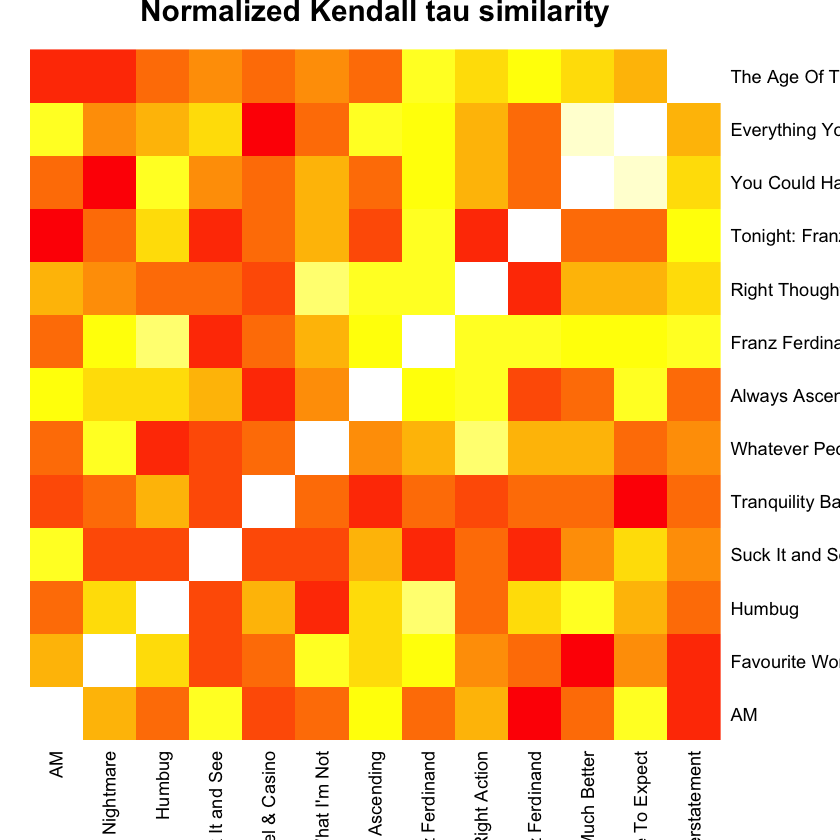

In [18]:
heatmap(as.matrix(1/ (1 + tau_kendall.df)), Colv = NA, Rowv = NA,
        main = "Normalized Kendall tau similarity", scale = 'none')